### Build and train the NASNet A Large network and retrain it by breast cancer data base

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Import the liberaries

In [ ]:
# !pip install pretrainedmodels
import torch
from torch import nn, optim
from torchvision import datasets ,transforms, models
import numpy as np
import matplotlib.pyplot as plt
import helper
import math
import time as evaltime
from torch import nn
from collections import OrderedDict

import pretrainedmodels
import tqdm
from tqdm import tqdm
import pandas as pd

#################################
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load the pre trained model and change the FC layer to taylor the number of classes: 8

In [0]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


nasnetalarge = 'nasnetalarge' 
nasnetalarge_2c = pretrainedmodels.__dict__[nasnetalarge](num_classes=1000, pretrained='imagenet')


In [0]:
classifier= nn.Sequential(OrderedDict([
    ('0', nn.Linear(4032,1024)),
    ('1',nn.ReLU(inplace=True)),
    ('2', nn.Dropout(p=0.5)),
    ('3', nn.Linear(1024,1024)),
    ('4',nn.ReLU(inplace=True)),
    ('5', nn.Dropout(p=0.5)),
    ('6', nn.Linear(1024,8)),
    ('output', nn.LogSoftmax(dim=1))
    
]))

nasnetalarge_2c.last_linear=classifier
for params in nasnetalarge_2c.parameters():
    params.required_grad=False
for params in nasnetalarge_2c.last_linear.parameters():
    params.required_grad=True

## Define the loss and optimization. in order to retrain the model, define the require grad true for all the parameters in the network.

In [ ]:
critirion= nn.NLLLoss()
optimizer = optim.Adam(nasnetalarge_2c.parameters(), lr=0.0002)
nasnetalarge_2c.to(device)


### load the images to the train and test loader, with the ratio of 90/10

In [7]:
dir_eight_Classes='To the brest cancer images for eight classifications/'
dir_checkpoints='To the /checkpoints/'
dir_statistics='To the/statistics/'


ratio=0.9 # split the train and test datasets with the ration of 90/10
train_transform = transforms.Compose([
    transforms.Resize((331,331)),
    transforms.RandomRotation(45),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomResizedCrop((224,224),scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

dataset= datasets.ImageFolder(dir_two_Classes,transform=train_transform)
train_sample_len=math.ceil(len(dataset)*ratio)
test_sample_len=len(dataset)-train_sample_len
trainset,testset=torch.utils.data.random_split(dataset,[train_sample_len,test_sample_len] )

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, num_workers=4, shuffle=True)
testloader =torch.utils.data.DataLoader(testset, batch_size=1, num_workers=4, shuffle=False)
classes=trainset.dataset.classes
print(len(dataset),classes)

7919 ['adenosis', 'ductal_carcinoma', 'fibroadenoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma', 'phyllodes_tumor', 'tubular_adenoma']


### Showing one image out of all to be confirmed that the trainset is already loaded

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


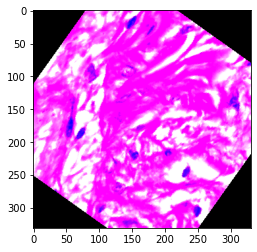

In [8]:
images=iter(testloader).next()
type(images)
images[0][0].shape
img=images[0][0].permute(1,2,0)
# images.size
plt.imshow(img)

### train the model

In [ ]:

epochs = 100
steps= 0
print_every=100
running_loss=0
min_val_loss = np.Inf
results={'epoch':[],'training_loss':[], 'test_loss':[], 'test_accuracy':[], 'training_accuracy':[]}

for e in range(1,epochs+1):
  running_results={'loss':0, 'accuracy':0,'minutes':0,'steps':0}
  nasnetalarge_2c.train()
  train_bar=tqdm(trainloader)
  running_loss=0

  for images, labels in train_bar:
      start_time= evaltime.time()
      images, labels = images.to(device), labels.to(device)
      running_results['steps']+=1
      optimizer.zero_grad()
      output=nasnetalarge_2c.forward(images)
      ps=torch.exp(output)
      loss=critirion(output,labels)
      loss.backward()
      optimizer.step()
      # running_loss+=loss.item()
      running_results['loss']+=loss.item()
      equality = (ps.max(dim=1)[1]==labels.data)
      running_results['accuracy']+=equality.type(torch.FloatTensor).mean()
      train_bar.set_description(desc='[%d/%d], training_loss: %.4f, training_accuracy: %.4f '% 
                                (e,epochs, running_results['loss']/running_results['steps'],running_results['accuracy']/running_results['steps']))
  test_bar=tqdm(testloader, desc='Validation Results:')
  nasnetalarge_2c.eval()
  valing_results={'test_loss':0, 'test_accuracy':0, 'min_loss':0, 'steps':0}


  with torch.no_grad():
    for images, labels in test_bar: 
      valing_results['steps']+=1
      images, labels = images.to(device), labels.to(device)
      output=nasnetalarge_2c.forward(images)
      loss=critirion(output,labels)
      valing_results['test_loss']+= loss.item()
      ps=torch.exp(output)
      equality = (ps.max(dim=1)[1]==labels.data)
      valing_results['test_accuracy']+=equality.type(torch.FloatTensor).mean()
      test_bar.set_description(desc='test_loss: %.4f, test_accuracy: %.4f'%
                               (valing_results['test_loss']/valing_results['steps'], valing_results['test_accuracy']/valing_results['steps'] ))
    if (valing_results['test_loss']/valing_results['steps']< min_val_loss):
            min_val_loss=valing_results['test_loss']/valing_results['steps']
            print('saving the model with min loss of : '+ str(min_val_loss))
            torch.save(nasnetalarge_2c.state_dict(),dir_checkpoints+"dataaug_FT1024_checkpoint_nasnetalarge_2c.pth")

     
  results['training_loss'].append(running_results['loss']/running_results['steps'])
  results['test_loss'].append(valing_results['test_loss']/valing_results['steps'])
  results['test_accuracy'].append(valing_results['test_accuracy'].item()/valing_results['steps'])
  results['training_accuracy'].append(running_results['accuracy'].item()/running_results['steps'])
  
  data_frame=pd.DataFrame(
        data={
            # 'Epoch':1,
            'Training_Loss':results['training_loss'],
            'Test_Loss': results['test_loss'],
            'Test_Accuracy':results['test_accuracy'],
            'Training_Accuracy':results['training_accuracy'],
           
                 },
        index=range(1,e+1)
    )
  data_frame.to_csv(dir_statistics+ 'dataaug_FT1024_nasnetalarge_2c_eval_results.csv',  index_label="Epoch")    